In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU


Using TensorFlow backend.


In [4]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [5]:
dataset = pd.read_csv(
    'raw.csv',
    parse_dates=[['year', 'month', 'day', 'hour']],
    index_col=0,
    date_parser=parse
)

In [6]:
dataset.head(10)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [7]:
dataset.drop('No', axis=1, inplace=True)

In [8]:
dataset.columns = [
    'pollution',
    'dew',
    'temp',
    'press',
    'wnd_dir',
    'wnd_spd',
    'snow',
    'rain'
]

dataset.index.name = 'date'

In [9]:
dataset['pollution'].fillna(0, inplace=True)

In [10]:
dataset = dataset[24:]

In [11]:
dataset.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [12]:
dataset.to_csv('pollution.csv')

In [13]:
data = pd.read_csv('pollution.csv', header=0, index_col=0)
data.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [14]:
values = data.values

groups = [0, 1, 2, 3, 5, 6, 7]

i = 1

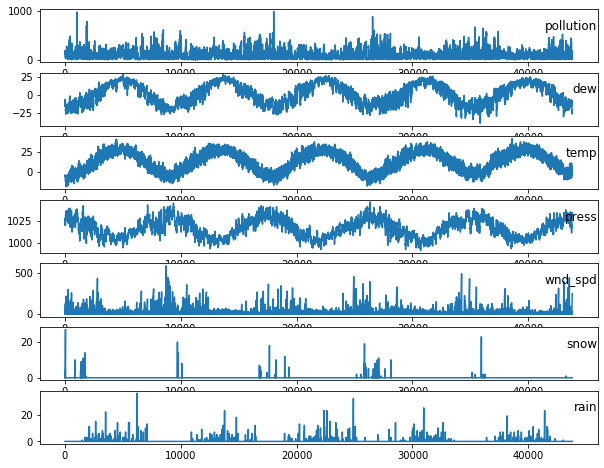

In [15]:
plt.figure(figsize=(10,8))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
labelEncoder = LabelEncoder()
data.iloc[:,4] = labelEncoder.fit_transform(data.iloc[:,4])
values = data.values
print(values.shape)
values = values.astype('float32')

(43800, 8)


In [18]:
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [19]:
series_to_supervised(values,1,1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.790000,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.680000,0.0,0.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.680000,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.570000,0.0,0.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.570000,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.360000,1.0,0.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.360000,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.250000,2.0,0.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.250000,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.140000,3.0,0.0
6,109.0,-7.0,-6.0,1022.0,2.0,7.140000,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.930000,4.0,0.0
7,105.0,-7.0,-6.0,1023.0,2.0,8.930000,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.720000,0.0,0.0
8,124.0,-7.0,-5.0,1024.0,2.0,10.720000,0.0,0.0,120.0,-8.0,-6.0,1024.0,2.0,12.510000,0.0,0.0
9,120.0,-8.0,-6.0,1024.0,2.0,12.510000,0.0,0.0,132.0,-7.0,-5.0,1025.0,2.0,14.300000,0.0,0.0
10,132.0,-7.0,-5.0,1025.0,2.0,14.300000,0.0,0.0,140.0,-7.0,-5.0,1026.0,2.0,17.430000,1.0,0.0


In [20]:
reframed = series_to_supervised(values,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0


In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [22]:
values = reframed.values
n_train = 365*24
train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

In [23]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


In [24]:
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [25]:
print(trainX.shape)
print(testX.shape)

(8760, 1, 8)
(35039, 1, 8)


In [26]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=0.2))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")

W0627 15:44:37.592705 140494615725888 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 15:44:37.607444 140494615725888 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 15:44:37.611204 140494615725888 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 15:44:37.729701 140494615725888 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

In [27]:
history = model.fit(
    trainX,
    trainY,
    validation_data=(testX, testY),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0627 15:44:38.479516 140494615725888 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0627 15:44:39.236444 140494615725888 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 8760 samples, validate on 35039 samples
Epoch 1/100
 - 3s - loss: 0.0562 - val_loss: 0.0366
Epoch 2/100
 - 1s - loss: 0.0347 - val_loss: 0.0228
Epoch 3/100
 - 1s - loss: 0.0308 - val_loss: 0.0203
Epoch 4/100
 - 1s - loss: 0.0309 - val_loss: 0.0204
Epoch 5/100
 - 1s - loss: 0.0301 - val_loss: 0.0204
Epoch 6/100
 - 1s - loss: 0.0306 - val_loss: 0.0198
Epoch 7/100
 - 1s - loss: 0.0302 - val_loss: 0.0199
Epoch 8/100
 - 1s - loss: 0.0294 - val_loss: 0.0202
Epoch 9/100
 - 1s - loss: 0.0291 - val_loss: 0.0190
Epoch 10/100
 - 1s - loss: 0.0295 - val_loss: 0.0190
Epoch 11/100
 - 1s - loss: 0.0287 - val_loss: 0.0188
Epoch 12/100
 - 1s - loss: 0.0292 - val_loss: 0.0192
Epoch 13/100
 - 1s - loss: 0.0292 - val_loss: 0.0189
Epoch 14/100
 - 1s - loss: 0.0279 - val_loss: 0.0179
Epoch 15/100
 - 1s - loss: 0.0281 - val_loss: 0.0180
Epoch 16/100
 - 1s - loss: 0.0285 - val_loss: 0.0185
Epoch 17/100
 - 2s - loss: 0.0280 - val_loss: 0.0186
Epoch 18/100
 - 2s - loss: 0.0274 - val_loss: 0.0178
Epoch 

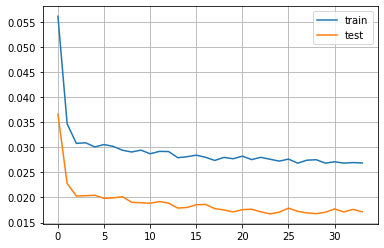

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
predicted = model.predict(testX)

In [30]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(testY, predicted)).round(5))

0.02983


In [31]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])

In [32]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [33]:
predicted.shape

(35039, 8)

In [34]:
predicted = scaler.inverse_transform(predicted)

In [35]:
testY = testY.reshape(len(testY), 1)

In [36]:
testY.shape

(35039, 1)

In [37]:
testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

In [38]:
testY = scaler.inverse_transform(testY)

In [39]:
#pd.DataFrame(testY)